# EDA

## Libraries

In [1]:
# pip install hic-straw==0.0.6

In [3]:
# pip install igraph

Note: you may need to restart the kernel to use updated packages.


In [1]:
import straw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import sklearn 
import networkx as nx
import igraph as ig
from itertools import count

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Kod z https://stackoverflow.com/a/49199019 generujący zawartość requiments.txt
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print('hic-straw==0.0.6')
for i in range(len(requirements)):
    print(f'{requirements[i][0]}=={requirements[i][1]}')

hic-straw==0.0.6
igraph==0.11.4
matplotlib==3.7.2
networkx==3.1
numpy==1.24.3
pandas==2.0.3
scikit-learn==1.2.2
seaborn==0.12.2


## Data load and preperation

In [71]:
# Data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525
# GSE63525_GM12878_diploid_maternal.hic
df = straw.straw("KR", "../Data/GSE63525_GM12878_diploid_maternal.hic",
    "11", "11", "BP", 500000) # "11", "11", "BP", 10000
# last argument is resolution (data per fragment) - smaller=finer details=more obserwations
# df to lista o wielu

# General idea of shape of the list
print(f'rows: {len(df)}')
print(f'columns: {max(len(row) for row in df)}')
# [lista_współrzędnych_x] , [lista_współrzędnych_y], [lista_zliczeń_kontaktów]

# Transforming list to data frame
df = pd.DataFrame(df).transpose()
df.columns = ['x', 'y', 'count']

df.loc[df['x'] == df['y'], 'count'] = 0

print('Unique values for x i y:')
print(df['x'].nunique())
print(df['y'].nunique())

HiC version:  7
rows: 3
columns: 35209
Unique values:
265
265


In [67]:
df_mean = df['count'].mean()
df_median = df['count'].median()
print('Mean count')
print(df_mean)
print('Median count')
print(df_median)
# df.loc[abs(df['x'] - df['y'])>30000000, 'count'] = 0
# # df.loc[df['count']<df_mean, 'count'] = 0
# df.loc[df['count']<df_median, 'count'] = 0

## Making a contact matrix

In [72]:
# Changing format from long to short to use as a matrix in plots
df_wide = df.pivot(index='x', columns='y', values='count')

In [73]:
# # Contact matrix with matplotlib (in-notebook preview doesn't work for larger data sizes)
# plt.imshow(df_wide, cmap='autumn', vmin=0)
# plt.gca().invert_yaxis()
# plt.legend().set_visible(False)
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)
# plt.gca().set_aspect('equal', adjustable='box')
# # plt.savefig('test.png', dpi=2500)
# plt.show()

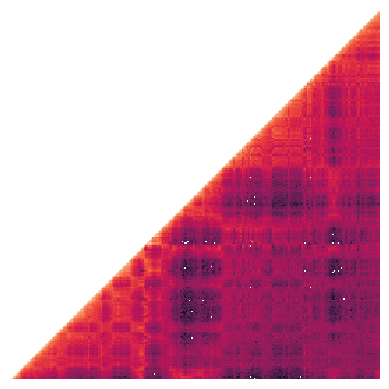

In [74]:
# Contact matrix with seaborn (better)
sns.heatmap(df_wide, cbar=False, vmin=0, square=True, norm=LogNorm())
plt.gca().invert_yaxis()
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
# plt.savefig('res1000000_normalisationKR.png', dpi=1000)
plt.show()

## Making a graph

In [11]:
# Creatinga en edgelist from dataframe 'df'

edges = pd.DataFrame({'source': df['x'],
                      'target': df['y'],
                      'weight': df['count']})

In [12]:
# Creating a graph from edgelist 'edges'

G = nx.from_pandas_edgelist(edges, 'source', 'target', 'weight')

In [13]:
# Nodes' poistion

position = nx.drawing.layout.spring_layout(G)
nx.set_node_attributes(G, position, 'pos')

# position = dict(zip(nodes["index"], nodes["position"].str.strip('array([])').str.split(',').apply(lambda x:[float(x) for x in x])))
# position

In [14]:
node_colors = range(len(G.nodes()))

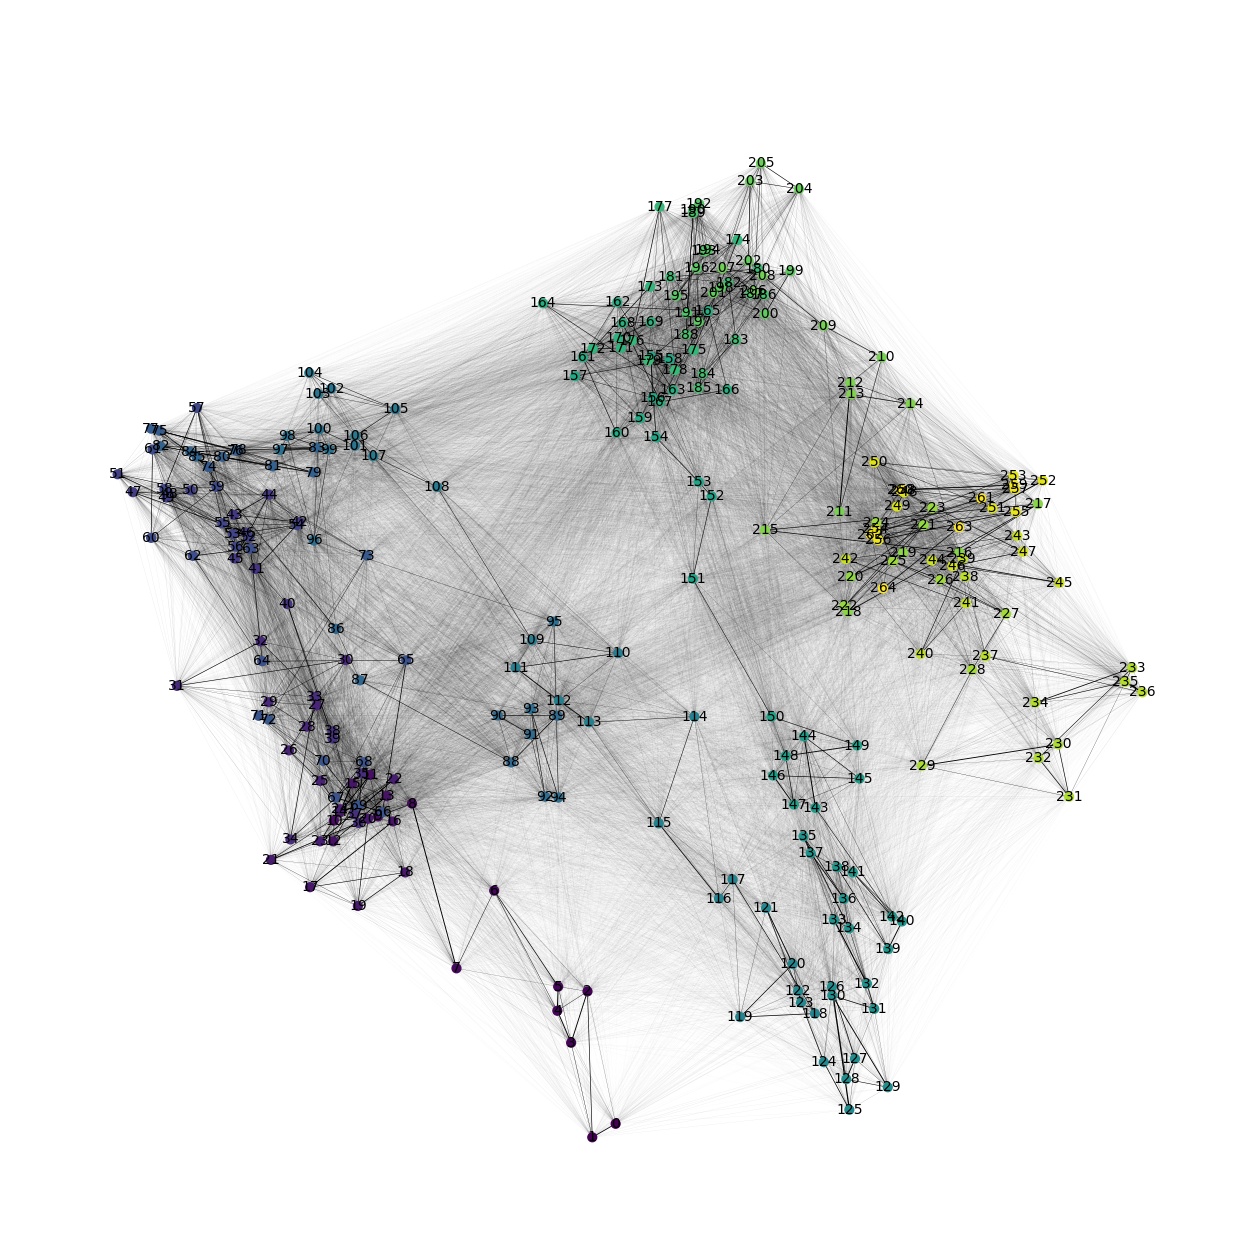

In [15]:
# Canvas
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

# Title
# plt.title('Faculty hiring networks in computer science', fontsize=20)

# Drawing the graph
nx.draw(G,
        pos = position,
        node_size = 40,
#         arrowsize = 15,
        width = [e[2]["weight"] * 0.0001 for e in G.edges(data=True)],
#         width = [e[2]["count"] * 0.1 for e in G.edges(data=True)], # ale tego nie dodaję, bo nie można wstawić dodatkowej legendy
#         width = 0.01,
#         node_color = node_colors,
        node_color=node_colors,
#         arrows=True,
#         connectionstyle = 'arc3,rad=0.05',
#         edge_color = edge_colors,
        ax = ax
       )

# Nodes' labels
for i, (node, (x, y)) in enumerate(position.items()):
    ax.text(x, y, i, fontsize = 10, ha = "center", va = "center")
# for i, (node, (x, y)) in enumerate(position.items()):
#     ax.text(x, y, nodes["institution"][i], fontsize = 10, ha = "center", va = "center")
    
# Description
# ax.text(0.01, 0.1, 
# """Each node is a PhD-granting institution in the respective field,
# and a directed edge (i,j) indicates that a person received 
# their PhD from node i and was tenure-track faculty at node j
# during time of collection (2011-2013)

# Acknowledgements:
# https://aaronclauset.github.io/facultyhiring/
# Citation:
# A. Clauset, S. Arbesman, and D. B. Larremore, "Systematic inequality and hierarchy in faculty hiring networks." Science Advances 1(1), e1400005 (2015)., https://doi.org/10.1126/sciadv.1400005 [@sci-hub]""", 
#     fontsize=8, 
#     transform=ax.transAxes,
#     verticalalignment="top" )

# Legend
# node_color_map = {
#     'Faculty region:': 'white',
#     'West (USA)': 'olive',
#     'Midwest (USA)': 'gold',
#     'Northeast (USA)': 'lightgreen',
#     'South (USA)': 'lightsalmon',
#     'Canada': 'orangered',
#     'Other': 'dodgerblue'
# }
# nodes_legend = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = label, markerfacecolor = color, markersize = 10)
#                       for label, color in node_color_map.items()]
# edges_color_map = {
#     "People's gender:": "white",
#     'Males': 'deepskyblue',
#     'Females': 'deeppink',
#     'Males and females': 'darkviolet'
# }
# edges_legend = [plt.Line2D([0], [0], marker = '>', color = 'w', label = label, markerfacecolor = color, markersize = 10)
#                       for label, color in edges_color_map.items()]
# plt.legend(handles = nodes_legend + edges_legend,
#            loc = 'upper left',
#            title = 'Legend')


# Saving the graph
# plt.savefig('WB1_EDA_test_1.pdf')
# plt.savefig('WB1_EDA_test_1.png', dpi=1000)

Igraph

In [1]:
# h = ig.Graph.from_networkx(G)

# layout = []
# for key in position.keys():
#     layout.append(position.get(key))

# # Plot the same network with NetworkX and igraph
# fig, ax = plt.subplots(1, 1, figsize=(16, 16))

# ax.set_title("Plot with igraph plot")
# ig.plot(h, layout=layout, target=ax)
# plt.axis("off")
# plt.show()

### For different data

KR, 11, 11, BP, 500.000

HiC version:  7
Unique values for x i y:
265
265
Mean count
121.3970310300261
Median count
43.80922173608237


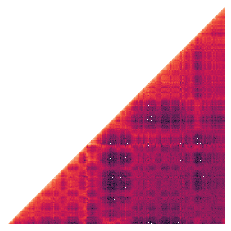

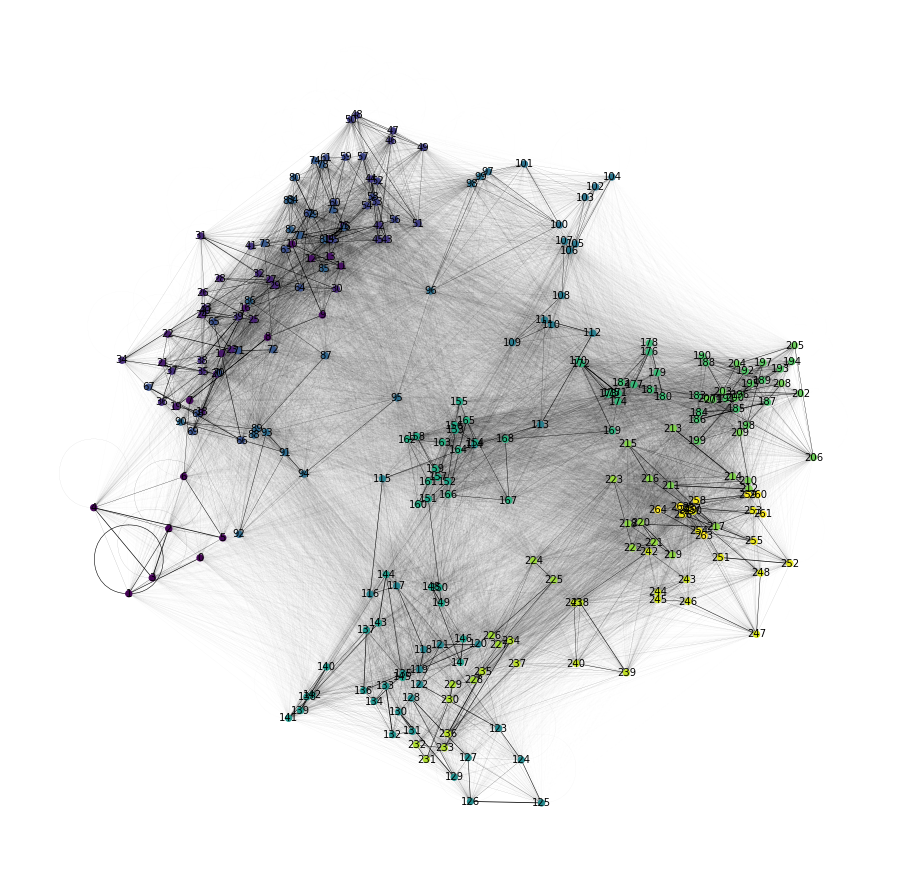

In [3]:
# Data load
df = straw.straw("KR",
"../Data/GSE63525_GM12878_diploid_maternal.hic",
    "11", "11", "BP", 500000)
df = pd.DataFrame(df).transpose()
df.columns = ['x', 'y', 'count']
df.loc[df['x'] == df['y'], 'count'] = 0
print('Unique values for x i y:')
print(df['x'].nunique())
print(df['y'].nunique())
df_mean = df['count'].mean()
df_median = df['count'].median()
print('Mean count')
print(df_mean)
print('Median count')
print(df_median)

# Contact matrix
df_wide = df.pivot(index='x', columns='y', values='count')
sns.heatmap(df_wide, cbar=False, vmin=0, square=True, norm=LogNorm())
plt.gca().invert_yaxis()
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.savefig('./ContactMatrixResults/test1.png', dpi=500)
plt.show()

# Graph
edges = pd.DataFrame({'source': df['x'],
                      'target': df['y'],
                      'weight': df['count']})
G = nx.from_pandas_edgelist(edges, 'source', 'target', 'weight')
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
position = nx.drawing.layout.spring_layout(G)
nx.set_node_attributes(G, position, 'pos')
node_colors = range(len(G.nodes()))
nx.draw(G,
        pos = position,
        node_size = 40,
        width = [e[2]["weight"] * 0.0001 for e in G.edges(data=True)],
        node_color=node_colors,
        ax = ax)
for i, (node, (x, y)) in enumerate(position.items()):
    ax.text(x, y, i, fontsize = 10, ha = "center", va = "center")
plt.savefig('./NetworkxGraphResults/test1.png', dpi=500)